In [5]:
import torch
import matplotlib.pyplot as plt

In [6]:
words = open('names.txt', 'r').read().splitlines()

In [7]:
chars = sorted(list(set(".".join(words)))); len(chars)

27

In [8]:
stoi = {c:i for i,c in enumerate(chars)}
itos = {c:i for i,c in stoi.items()}
itos[0], stoi["."]

('.', 0)

In [198]:
# Simple bigram model created using counts
N = torch.zeros(27, 27, dtype=torch.int32)
for w in words:
  w = ['.'] + list(w) + ['.']
  for c1, c2 in zip(w, w[1:]):
    i1, i2 = stoi[c1], stoi[c2]
    N[i1,i2] += 1

(-0.5, 26.5, 26.5, -0.5)

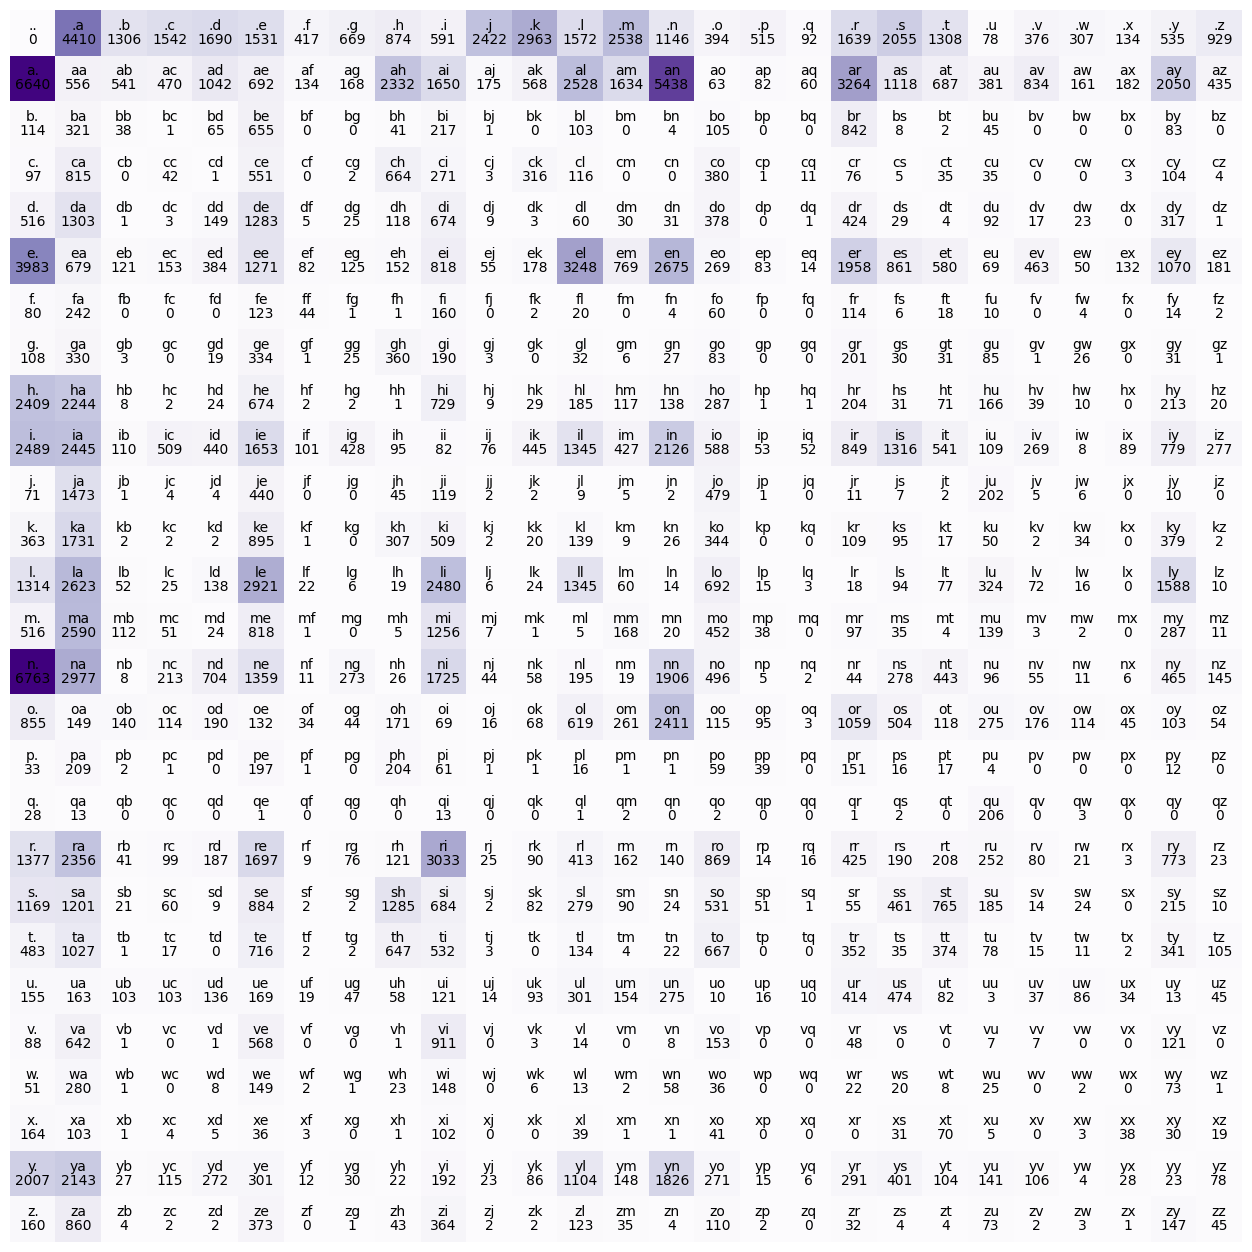

In [199]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Purples')
for i in range(N.shape[0]):
  for j in range(N.shape[1]):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='black')
    plt.text(j, i, N[i,j].item(), ha='center', va='top', color='black')
plt.axis('off')

In [200]:
p = N[0].float()
p = p/p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [201]:
g = torch.Generator().manual_seed(234124)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[idx]

'k'

In [202]:
P = (N+1).float() # +1 for model smoothening
P /= P.sum(1, keepdim=True)

In [227]:
for i in range(4):
  out = []
  idx = 0
  while True:
    p = P[idx]
    idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[idx])
    if idx == 0: break
  print("".join(out))

a.
ah.
man.
rip.


In [228]:
# loss function
n = 0
ll = 0.

for w in words:
  w = ['.'] + list(w) + ['.']
  for c1, c2 in zip(w, w[1:]):
    i1, i2 = stoi[c1], stoi[c2]
    prob = P[i1, i2]
    lprob = torch.log(prob)
    ll += lprob
    n += 1

log_likelihood = (ll/n).item()
print(f"{ll.item():.4f}")
print(f"{log_likelihood=:.4f}")
print(f"{-log_likelihood:.4f}")

-559951.5625
log_likelihood=-2.4544
2.4544


### Deep learning

In [229]:
# Creating XS and YS
xs,ys = [],[]

for w in words:
  w = ['.'] + list(w) + ['.']
  for c1, c2 in zip(w, w[1:]):
    i1, i2 = stoi[c1], stoi[c2]
    print(c1, c2)
    xs.append(i1)
    ys.append(i2)
  break

xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs)
print(ys)

. e
e m
m m
m a
a .
tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


In [230]:
# Calculating loss for one word "emma"
import torch.nn.functional as F

g = torch.Generator().manual_seed(234124)
W = torch.randn(27, 27, generator=g, requires_grad=True)

In [231]:
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc@W
counts = logits.exp()
probs = counts/counts.sum(1, keepdim=True)
loss = -probs[range(5), ys].log().mean()
loss

tensor(4.3394, grad_fn=<NegBackward0>)

In [11]:
loss.backward()

In [12]:
# step
W.data -= W.grad.data * 0.01

In [381]:
# nlls = torch.zeros(5)

# for i in range(5):
#   x = xs[i].item()
#   y = ys[i].item()
#   p = probs[i, y]
#   logp = p.log()
#   nll = -logp
#   nlls[i] = nll

# nlls.mean()

In [382]:
# same but more efficient, because no loop, :D
# -probs[range(5), ys].log().mean()

### Loop

In [232]:
xs, ys = [], []
for w in words:
  w = ['.'] + list(w) + ['.']
  for c1, c2 in zip(w, w[1:]):
    i1, i2 = stoi[c1], stoi[c2]
    xs.append(i1)
    ys.append(i2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

g = torch.Generator().manual_seed(234124)
W = torch.randn(27, 27, generator=g, requires_grad=True)

nums = xs.shape[0]

In [233]:
xs[:5]

tensor([ 0,  5, 13, 13,  1])

In [237]:
for k in range(100):
  W.grad = None
  xenc = F.one_hot(xs, num_classes=27).float()
  logits = xenc@W
  counts = logits.exp()
  probs = counts/counts.sum(1, keepdim=True)
  loss = -probs[range(nums), ys].log().mean() + 0.01*(W**2).mean()
  print(f"{loss.item():.4f}")

  loss.backward()
  # W.grad += wd * 2 * W
  W.data -= W.grad.data * 50

2.4861
2.4860
2.4859
2.4858
2.4857
2.4856
2.4855
2.4854
2.4853
2.4852
2.4852
2.4851
2.4850
2.4849
2.4849
2.4848
2.4847
2.4846
2.4846
2.4845
2.4844
2.4844
2.4843
2.4842
2.4842
2.4841
2.4841
2.4840
2.4839
2.4839
2.4838
2.4838
2.4837
2.4837
2.4836
2.4836
2.4835
2.4835
2.4834
2.4834
2.4834
2.4833
2.4833
2.4832
2.4832
2.4831
2.4831
2.4831
2.4830
2.4830
2.4830
2.4829
2.4829
2.4828
2.4828
2.4828
2.4827
2.4827
2.4827
2.4826
2.4826
2.4826
2.4826
2.4825
2.4825
2.4825
2.4824
2.4824
2.4824
2.4824
2.4823
2.4823
2.4823
2.4823
2.4822
2.4822
2.4822
2.4822
2.4821
2.4821
2.4821
2.4821
2.4820
2.4820
2.4820
2.4820
2.4820
2.4819
2.4819
2.4819
2.4819
2.4819
2.4818
2.4818
2.4818
2.4818
2.4818
2.4818
2.4817
2.4817


Visualizing the weight matrix

(-0.5, 26.5, 26.5, -0.5)

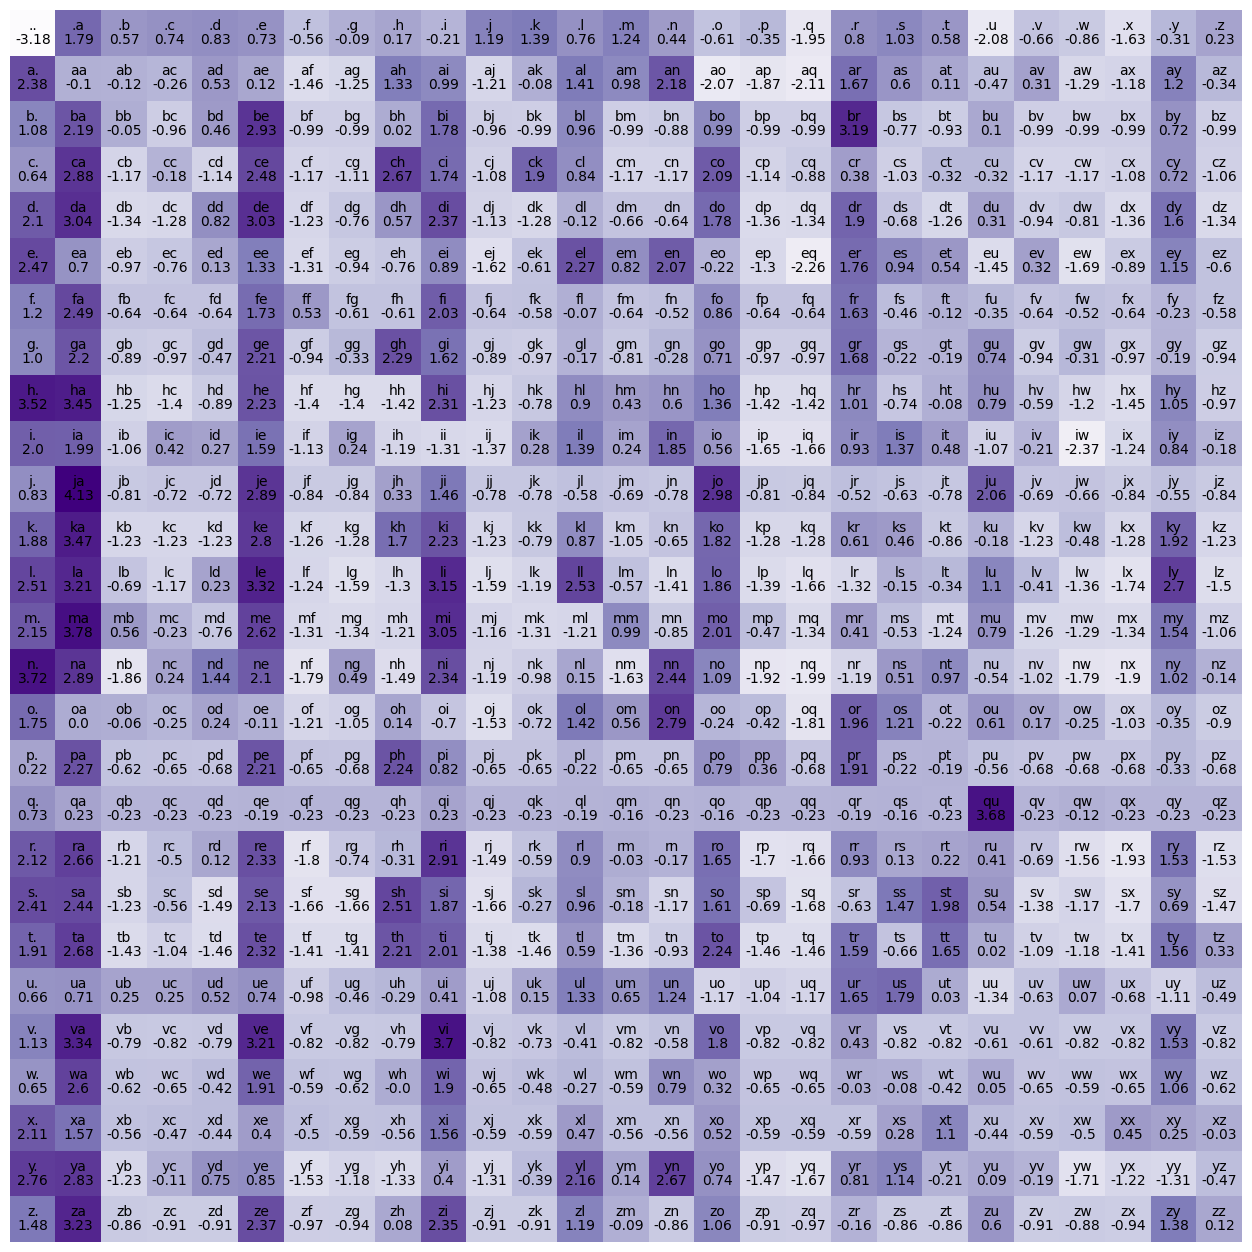

In [238]:
plt.figure(figsize=(16,16))
plt.imshow(W.data, cmap='Purples')
for i in range(W.shape[0]):
  for j in range(W.shape[1]):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='black')
    plt.text(j, i, round(W[i,j].item(), 2), ha='center', va='top', color='black')
plt.axis('off')

Sampling

In [243]:
for i in range(4):
  out = []
  idx = 0
  while True:
    xenc = F.one_hot(torch.tensor([idx]), num_classes=27).float()
    logits = xenc@W
    counts = logits.exp()
    p = counts/counts.sum(1, keepdim=True)
    idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[idx])
    if idx == 0: break
  print("".join(out))

saalusis.
lale.
njelenn.
gh.


# Trigram implementation

In [244]:
import torch.nn.functional as F

In [245]:
# E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?
xs,ys = [],[]

for w in words:
  w = ['.'] + list(w) + ['.']
  for i in range(len(w)-2):
    x = [stoi[k] for k in w[i:i+2]]
    y = stoi[w[i+2]]
    xs.append(x)
    ys.append(y)

xs, ys = torch.tensor(xs), torch.tensor(ys)

In [349]:
import numpy as np
from functools import reduce

sz = (54,27)
t_sz = reduce(lambda x,y: x*y, sz) if sz else 1
w = torch.tensor(np.random.uniform(-1., 1., size=sz)/np.sqrt(t_sz), requires_grad=True, dtype=torch.float32)

g = torch.Generator().manual_seed(234124)

# W = torch.randn(54, 27, generator=g, requires_grad=True)

xenc = F.one_hot(xs, num_classes=27).float()
num = xenc.shape[0]

xenc = xenc.view(num, -1)
loss_func = torch.nn.CrossEntropyLoss()
xenc.shape

torch.Size([196113, 54])

In [350]:
for k in range(100):
  W.grad = None
  logits = xenc@W
  loss = loss_func(logits, ys) + 0.01 * (W**2).mean()
  print(f"{loss:.4f}")
  loss.backward()
  # W.grad += 0.01 * 2 * W # Regularization # Weight decay
  W.data -= W.grad.data * 50

2.2652
2.2650
2.2649
2.2647
2.2646
2.2644
2.2643
2.2641
2.2640
2.2638
2.2637
2.2636
2.2634
2.2633
2.2632
2.2630
2.2629
2.2628
2.2627
2.2626
2.2624
2.2623
2.2622
2.2621
2.2620
2.2619
2.2618
2.2617
2.2616
2.2615
2.2614
2.2613
2.2612
2.2611
2.2610
2.2609
2.2608
2.2607
2.2606
2.2606
2.2605
2.2604
2.2603
2.2602
2.2601
2.2601
2.2600
2.2599
2.2598
2.2598
2.2597
2.2596
2.2595
2.2595
2.2594
2.2593
2.2593
2.2592
2.2591
2.2591
2.2590
2.2589
2.2589
2.2588
2.2587
2.2587
2.2586
2.2586
2.2585
2.2585
2.2584
2.2583
2.2583
2.2582
2.2582
2.2581
2.2581
2.2580
2.2580
2.2579
2.2579
2.2578
2.2578
2.2577
2.2577
2.2576
2.2576
2.2575
2.2575
2.2574
2.2574
2.2574
2.2573
2.2573
2.2572
2.2572
2.2571
2.2571
2.2571
2.2570


Trigram Sampling

In [90]:
W.shape

torch.Size([54, 27])

In [428]:
for k in range(4):
  out = []
  idx = 0
  while True:
    x2 = F.one_hot(torch.tensor([idx]), num_classes=54).float()
    logits = x2@W # 1, 27
    preds = logits.softmax(dim=1)
    idx = torch.multinomial(preds,num_samples=1, replacement=True).item()
    out.append(itos[idx])
    if idx == 0: break
  print("".join(out))

seoia.
pregde.
liajvahi.
i.


In [448]:
# split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?


indices = np.random.randint(0,int(len(words)*0.8), size=len(words))
train = [words[i] for i in indices]

indices = np.random.randint(0,int(len(words)*0.1), size=len(words))
valid = [words[i] for i in indices]

indices = np.random.randint(0,int(len(words)*0.1), size=len(words))
test = [words[i] for i in indices]


# Creating XS and YS
xs,ys = [],[]
for w in train:
  w = ['.'] + list(w) + ['.']
  for c1, c2 in zip(w, w[1:]):
    i1, i2 = stoi[c1], stoi[c2]
    xs.append(i1)
    ys.append(i2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

torch.Size([228623])
torch.Size([228623])


In [627]:
W = torch.rand(27, 27, requires_grad=True).float()
loss_func = torch.nn.CrossEntropyLoss()

In [631]:
lr = 1
WD = 0.01
i = 0

while True:
  i+=1
  W.grad = None

  xenc = W[xs]
  preds = (xenc@W).softmax(dim=1)
  loss = -preds[range(xs.shape[0]), ys].log().mean()
  # loss = [preds, ys] + WD * (W**2).mean()
  print(f"{i} | loss: {loss:.4f}")
  loss.backward()
  W.data -= W.grad.data * lr
  if loss < 2: break

1 | loss: 4.2307
2 | loss: 3.2393
3 | loss: 3.0308
4 | loss: 2.9353
5 | loss: 2.8840
6 | loss: 2.8488
7 | loss: 2.8217
8 | loss: 2.7998
9 | loss: 2.7814
10 | loss: 2.7656
11 | loss: 2.7516
12 | loss: 2.7391
13 | loss: 2.7277
14 | loss: 2.7173
15 | loss: 2.7077
16 | loss: 2.6988
17 | loss: 2.6905
18 | loss: 2.6827
19 | loss: 2.6754
20 | loss: 2.6686
21 | loss: 2.6621
22 | loss: 2.6560
23 | loss: 2.6503
24 | loss: 2.6448
25 | loss: 2.6396
26 | loss: 2.6347
27 | loss: 2.6300
28 | loss: 2.6256
29 | loss: 2.6214
30 | loss: 2.6173
31 | loss: 2.6135
32 | loss: 2.6098
33 | loss: 2.6063
34 | loss: 2.6029
35 | loss: 2.5997
36 | loss: 2.5966
37 | loss: 2.5936
38 | loss: 2.5908
39 | loss: 2.5880
40 | loss: 2.5854
41 | loss: 2.5829
42 | loss: 2.5805
43 | loss: 2.5781
44 | loss: 2.5758
45 | loss: 2.5737
46 | loss: 2.5716
47 | loss: 2.5695
48 | loss: 2.5676
49 | loss: 2.5656
50 | loss: 2.5638
51 | loss: 2.5620
52 | loss: 2.5603
53 | loss: 2.5586
54 | loss: 2.5570
55 | loss: 2.5554
56 | loss: 2.5538
5

KeyboardInterrupt: 

In [643]:
# Sampling
for k in range(4):
  out = []
  idx = 0
  while True:
    x2 = F.one_hot(torch.tensor([idx]), num_classes=27).float()
    logits = x2@W # 1, 27
    preds = logits.softmax(dim=1)
    idx = torch.multinomial(preds,num_samples=1, replacement=True).item()
    out.append(itos[idx])
    if idx == 0: break
  print("".join(out))

hbw.
al.
frgrsdn.
dunndtnfxv.


In [ ]:
# Exercises:

# E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W? 
# -- directly indexing!

# E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead? 
# -- because, CELoss do--
# logits -> Softmax -> Loglikelihood -> preds

# E06: meta-exercise! Think of a fun/interesting exercise and complete it.